# Moving Average Smoothing and MA(q)
- TUTORIAL: [Moving Average Smoothing for Data Preparation and Time Series Forecasting in Python](https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/) by Jason Brownlee

- CODE: [MA](https://github.com/marcopeix/TimeSeriesForecastingInPython/blob/master/CH04/CH04.ipynb) by Marco Peixeiro 

- TUTORIAL: [Time series: A simple moving average (MA) model](https://www.kaggle.com/code/carlmcbrideellis/time-series-a-simple-moving-average-ma-model) by Carl Mcbride Ellis

## TODOs
- [x] Finish reproducing Jason's tutorial
- [ ] Finish reproducing Marco's code

In [1]:
import os
import sys

# Get the current working directory of the notebook
notebook_dir = os.getcwd()
print(notebook_dir)

# Add the parent directory to the system path
sys.path.append(os.path.join(notebook_dir, '../framework_for_time_series_data/tslearn/'))

import warnings
warnings.filterwarnings('ignore')

from collections import namedtuple
from ts_models import Model, MA, EvaluationMetric
from data_loader import build_any_univariate_time_series, build_stock_uts
from time_series import TimeSeriesFactory, UnivariateTimeSeries

/Users/brinkley97/Documents/development/applied_time_series_and_machine_learning/play


## MA Smoothing by Jason

In [2]:
path_to_file = "../datasets/daily-total-female-births.csv"
ts = build_any_univariate_time_series(path_to_file)
ts

UnivariateTimeSeries(Observations)

In [3]:
ts.get_as_df()

,Observations
Timestamp,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44
...,...
1959-12-27,37
1959-12-28,52
1959-12-29,48


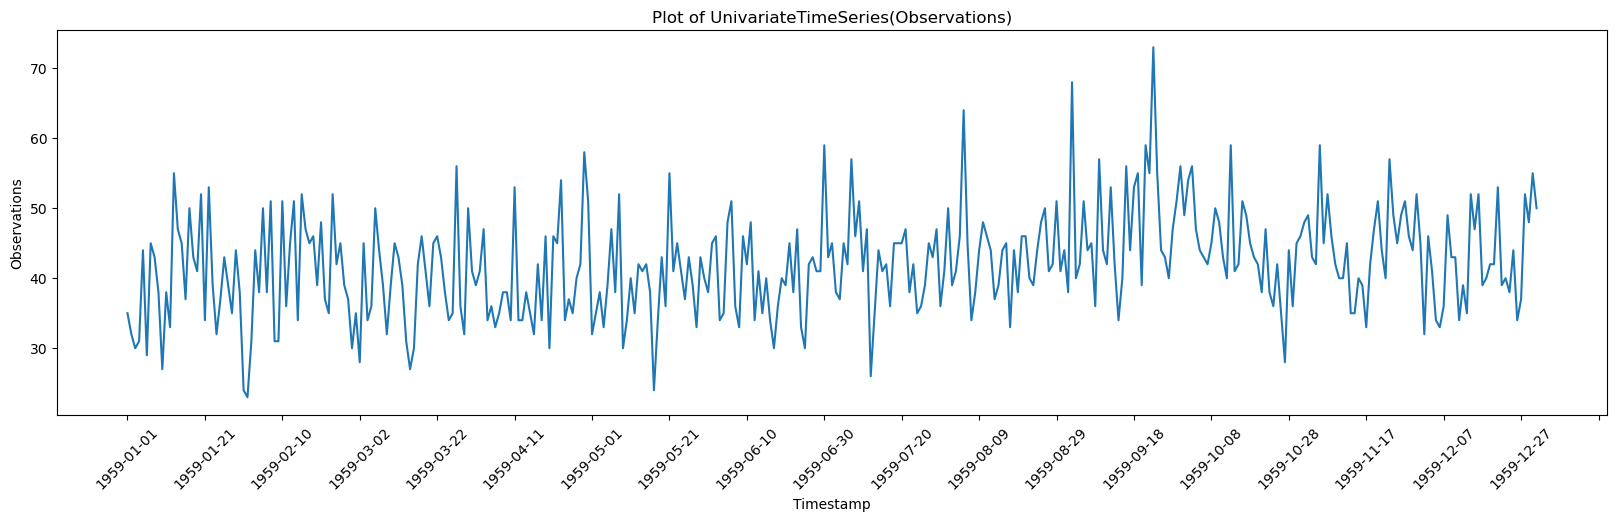

In [4]:
ts.plot(tick_skip=20)

#### Analogy for smoothing
- Smoothing is like having a rope. Say I'm on one end and you're on the other end and our rope goes to 100 yards (imagine a football field). We start close together, say at the 50. Our rope will be bunched up. When we apply smoothing, we take steps in the opposite direction with the rope becoming straighter or more leveled out.

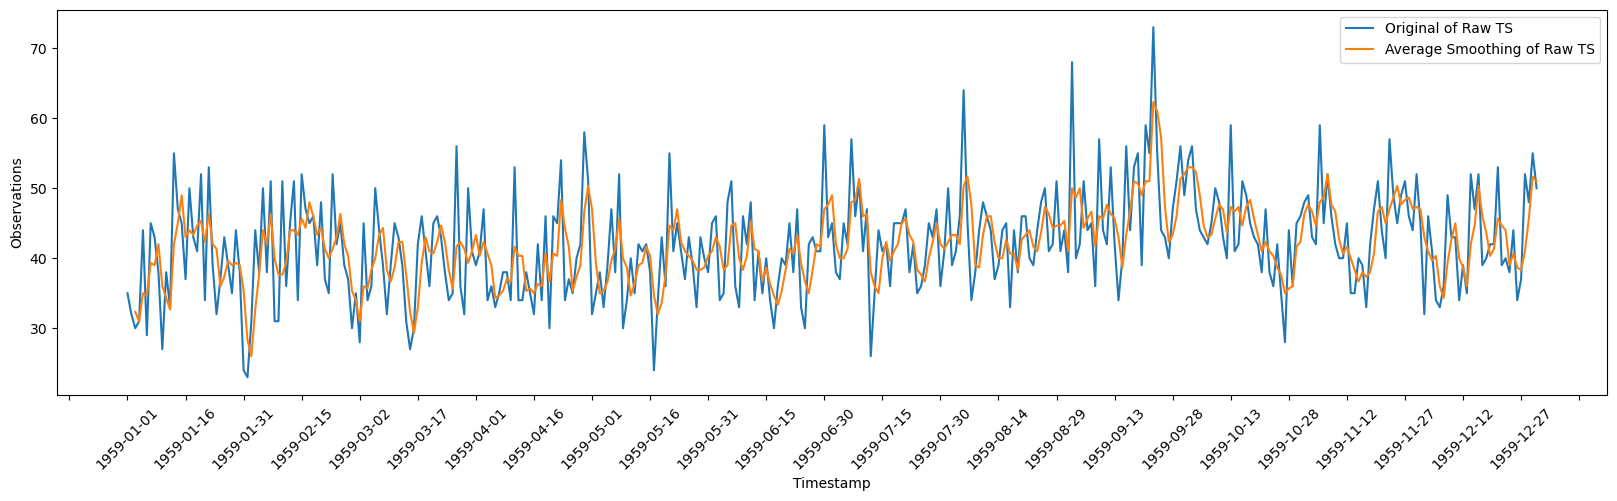

In [5]:
ts_with_avg_smoothing = ts.average_smoothing(3)

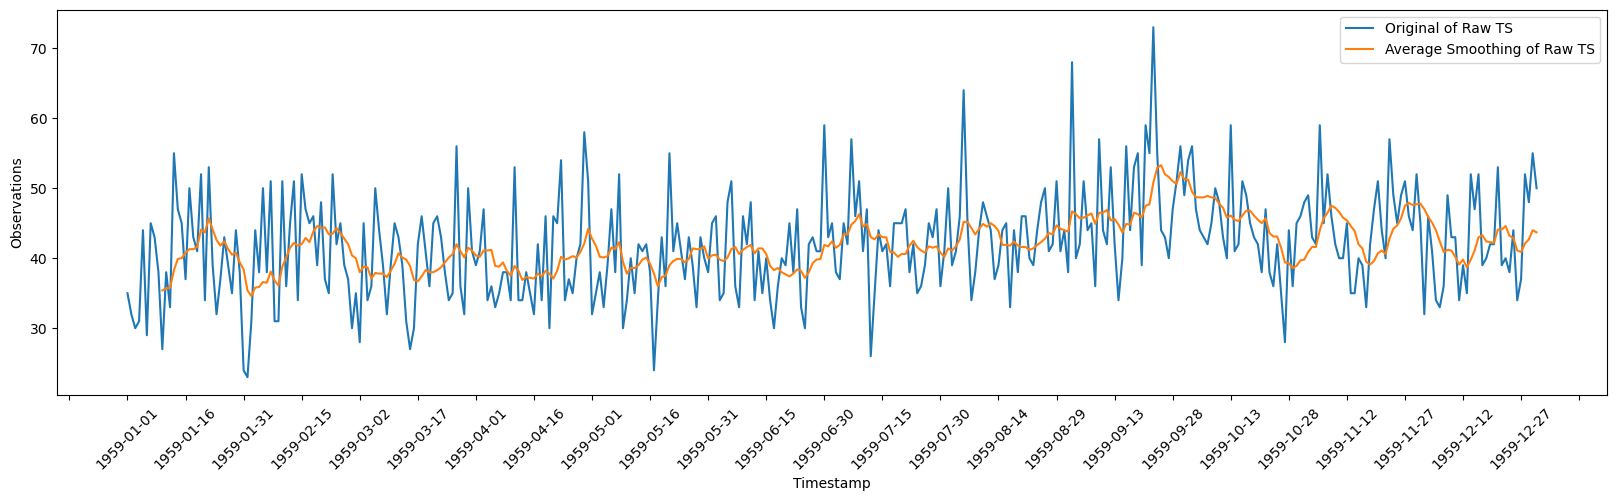

In [6]:
ts_with_avg_smoothing = ts.average_smoothing(10)

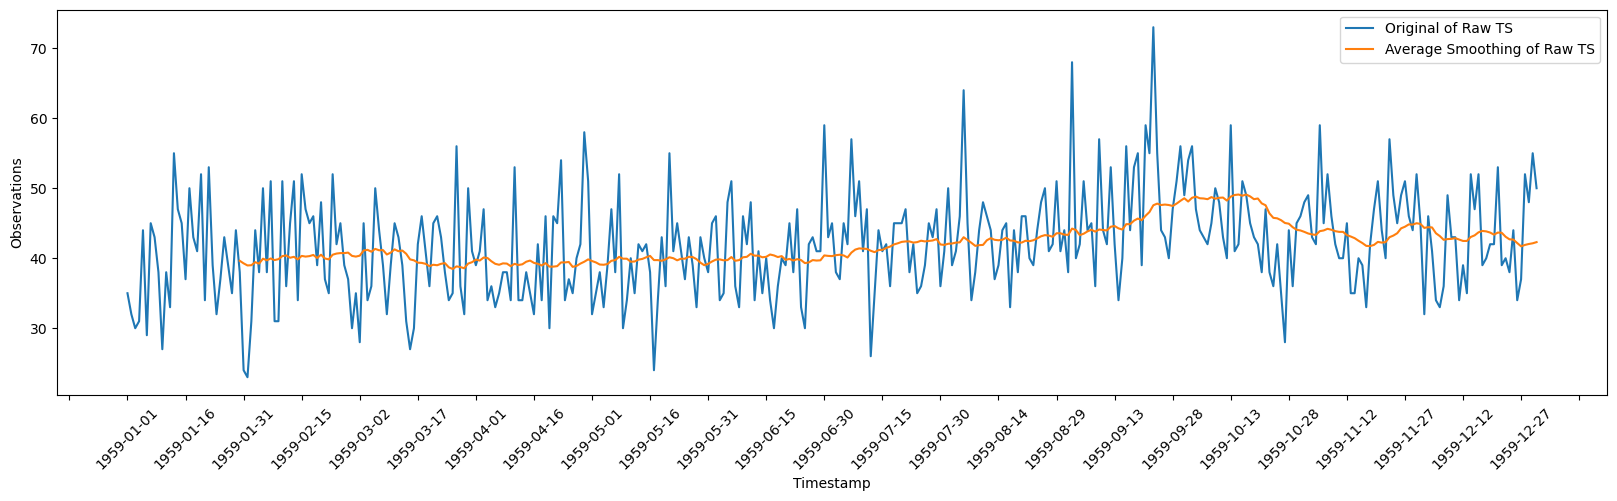

In [7]:
ts_with_avg_smoothing = ts.average_smoothing(30)

---

## MA Modeling by Marco

In [8]:
path_to_file = "../datasets/widget_sales.csv"
ws_ts = build_any_univariate_time_series(path_to_file)
ws_ts

UnivariateTimeSeries(Observations)

In [9]:
ws_ts_df = ws_ts.get_as_df()
ws_ts_df

,Observations
Timestamp,
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108
...,...
495,64.087371
496,63.992081
497,63.029894


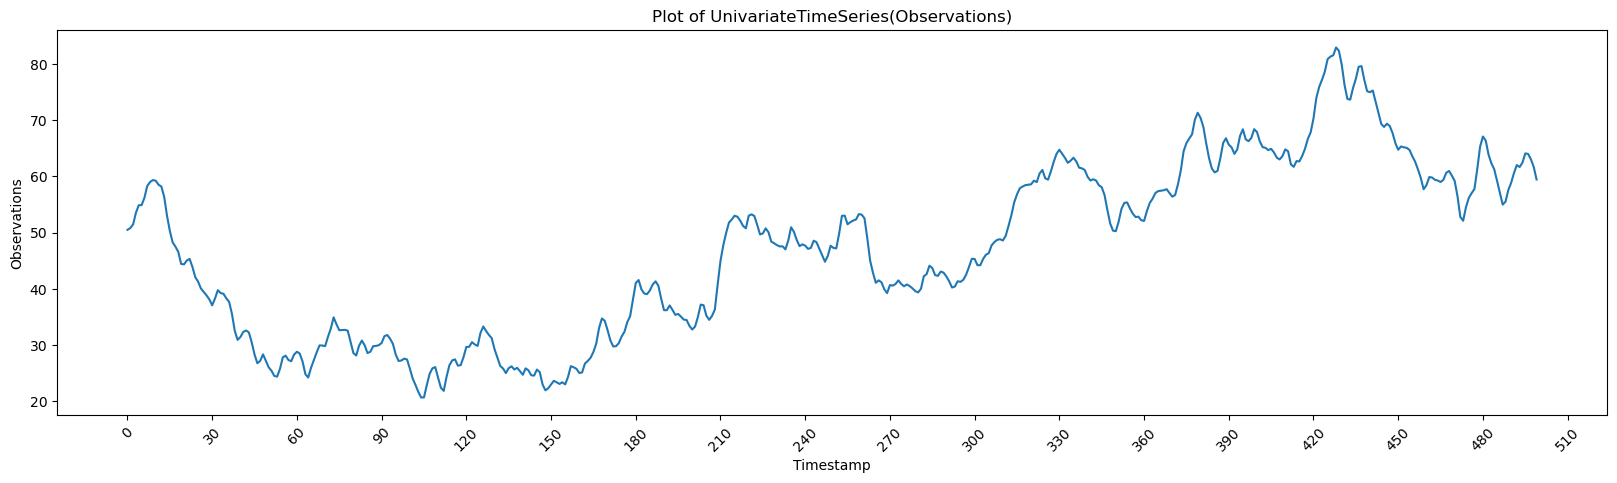

In [10]:
ws_ts.plot(tick_skip=30)

- A negative trend exists from 0 to ~60.
- A positive trend exists from 150 to ~430.
- Possibly cyclic behavior in windows of (1) 270 to 350, (2) 350 to 410, and (3) 390 to 425 as all have a positive trend, then a small negative dip.

In [11]:
ws_ts.stationarity_test(ws_ts_df)

ADF Statistic: -1.512166
p-value: 0.527485 > 0.05 , so accept the null-hypothesis as the TS is non-stationary
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


In [12]:
ws_ts_diff = ws_ts.data_augment_with_differencing(1)
ws_ts_diff, len(ws_ts_diff)

(UnivariateTimeSeries(Order-1 Difference of Observations), 499)

In [13]:
ws_ts_diff_df = ws_ts_diff.get_as_df()
ws_ts_diff_df

,Order-1 Difference of Observations
Timestamp,
1,0.308778
2,0.672265
3,2.064470
4,1.330880
5,0.012034
...,...
495,1.651336
496,-0.095290
497,-0.962187


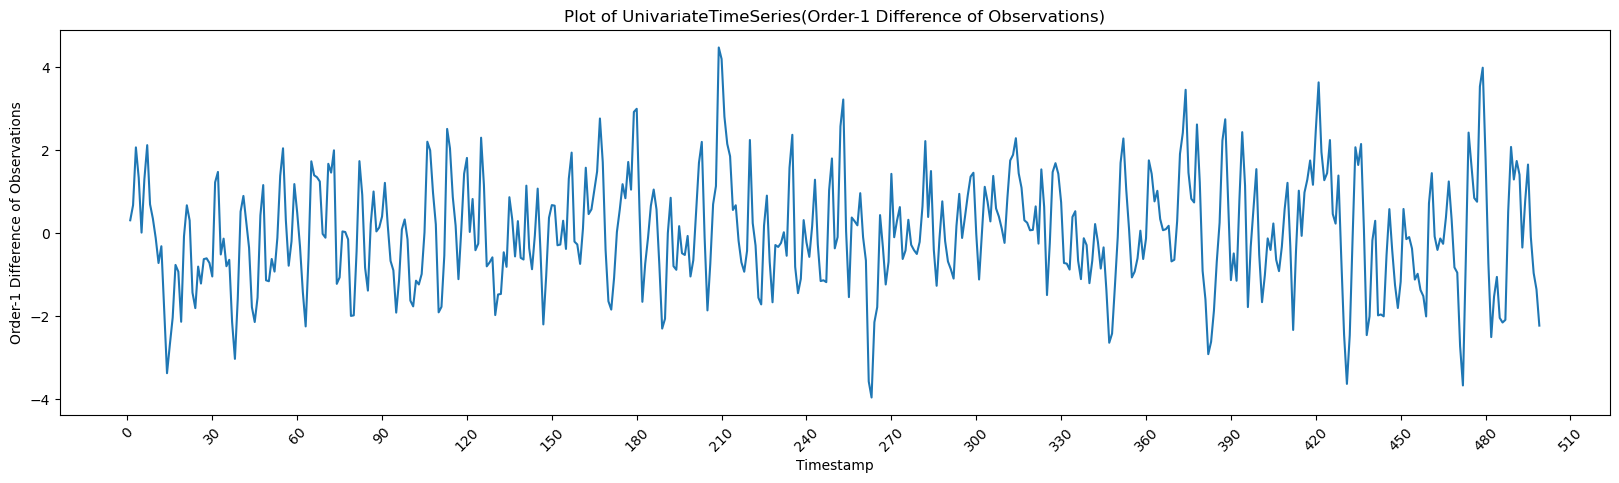

In [14]:
ws_ts_diff.plot(tick_skip=30)

In [15]:
ws_ts_diff.stationarity_test(ws_ts_diff.get_as_df())

ADF Statistic: -10.576658
p-value: 0.000000 < 0.05 , so reject null-hypothesis as the TS is stationary
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


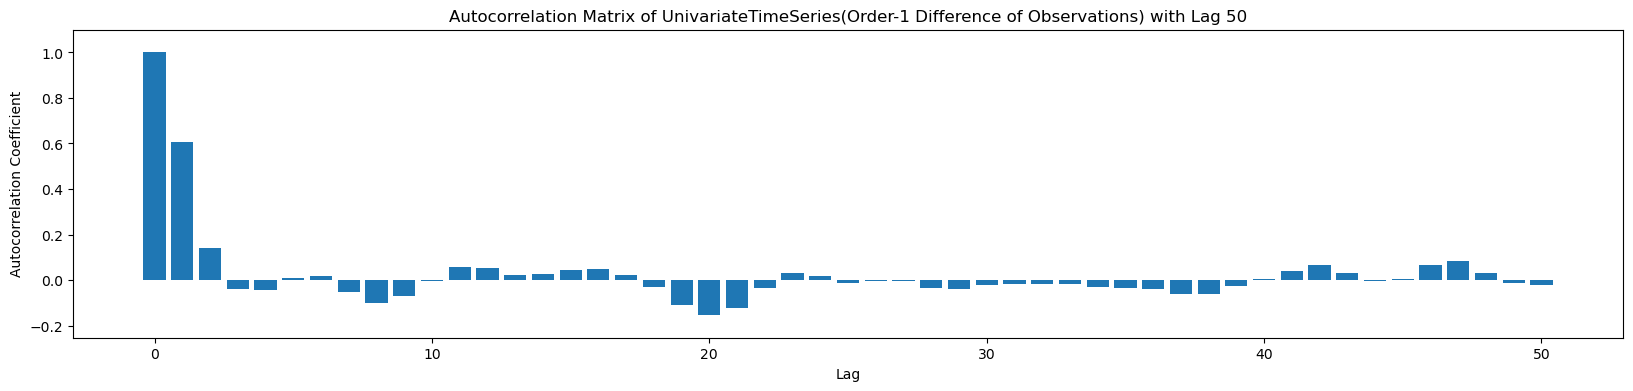

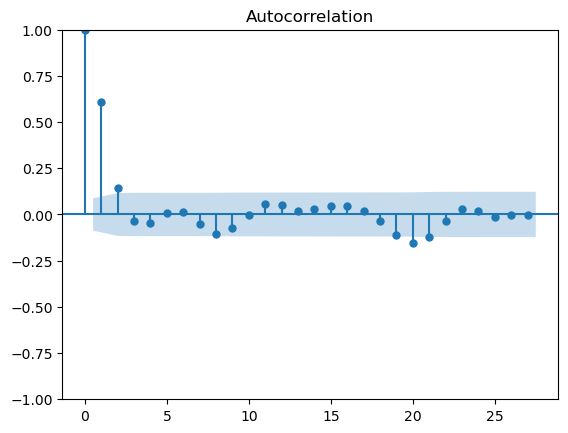

In [16]:
ws_ts_diff.plot_autocorrelation(50)

- A slow decline from the current observation, thus there exists correlation (also called dependence) between the current observation up to lag 2. 
- Seems to be a cycle starting at lag 3. 
- `MA(q)` = [2, 3], 2 bc there's little dependence and 3 because there's no dependence which proves the stationary assumption for MA (because it's within the confidence region)

In [17]:
observations_to_forecast = [50]

for i in range(len(observations_to_forecast)):
    len_of_total_observations = len(ws_ts_diff.get_series())
    print(f'Total observations {len_of_total_observations}')
    
    len_of_test_observations = observations_to_forecast[i]
    print(f'Test observations considered {len_of_test_observations}')
    
    len_of_training_observations = len_of_total_observations - len_of_test_observations
    print(f'Training observations considered {len_of_training_observations}\n')

Total observations 499
Test observations considered 50
Training observations considered 449



In [18]:
training_observations_df = ws_ts_diff.get_as_df()[:len_of_training_observations]
training_observations_df

,Order-1 Difference of Observations
Timestamp,
1,0.308778
2,0.672265
3,2.064470
4,1.330880
5,0.012034
...,...
445,-0.531086
446,0.577963
447,-0.409040


In [19]:
test_observations_df = ws_ts_diff.get_as_df()[len_of_training_observations:]
len(test_observations_df), test_observations_df

(50,
            Order-1 Difference of Observations
 Timestamp                                    
 450                                 -1.170131
 451                                  0.580967
 452                                 -0.144902
 453                                 -0.096564
 454                                 -0.372334
 455                                 -1.118891
 456                                 -0.979693
 457                                 -1.369431
 458                                 -1.517477
 459                                 -2.006735
 460                                  0.720540
 461                                  1.444153
 462                                 -0.078571
 463                                 -0.405194
 464                                 -0.129664
 465                                 -0.257871
 466                                  0.381596
 467                                  1.243967
 468                                  0.335506
 469    

In [20]:
ma_model_class = MA()
ma_model_class

MA()

In [21]:
len_of_training_observations, len_of_test_observations

(449, 50)

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [23]:
window = 2
q = 2
ma_predictions = ma_model_class.train_predict_ma_model(ws_ts_diff_df, len_of_training_observations, len_of_test_observations, window, q)

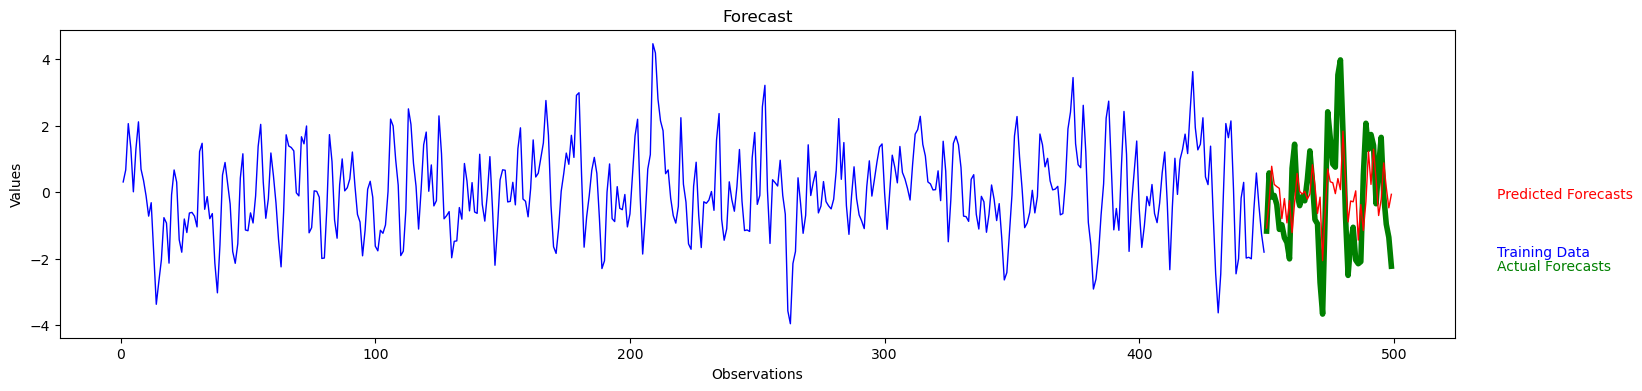

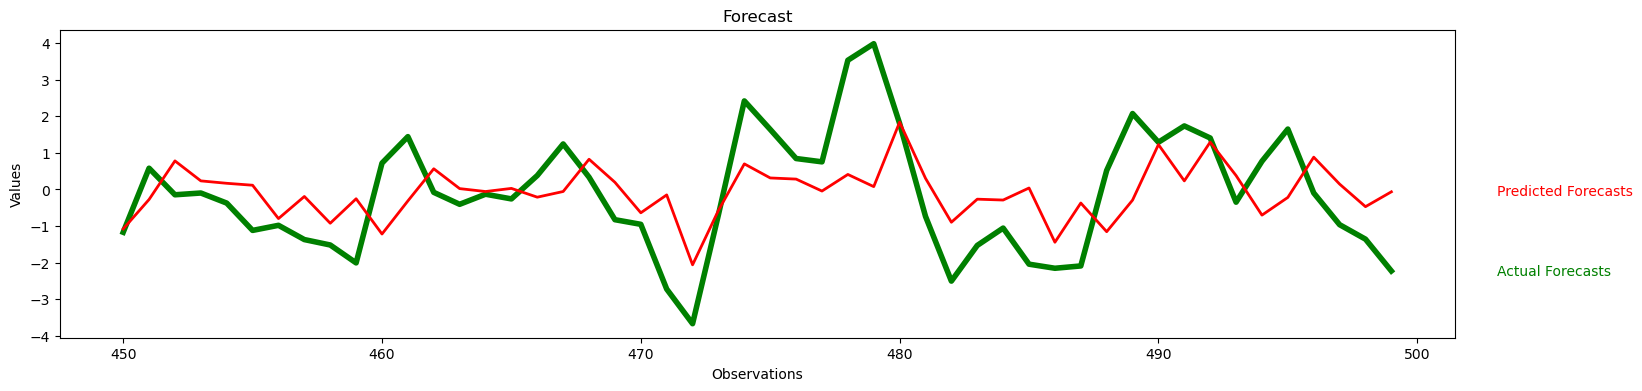

In [24]:
EvaluationMetric.plot_forecast(training_observations_df, test_observations_df, ma_predictions, per_element=False)
EvaluationMetric.plot_forecast_only(test_observations_df, ma_predictions, per_element=False)

In [37]:
ma_mse = EvaluationMetric.eval_mse(test_observations_df, ma_predictions, per_element=False)
ma_rmse = EvaluationMetric.eval_rmse(test_observations_df, ma_predictions, per_element=False)

Test MSE: 1.948
Test RMSE: 1.396


---

## MA Modeling by Carl

In [ ]:
# import yfinance as yf
# IBEX = yf.Ticker("^IBEX")
# # get historical market data
# IBEX_values = IBEX.history(start="2020-06-01")

In [ ]:
# IBEX_values

In [ ]:
stock_symbol = "^IBEX" 
stock_name = "Ibex Ltd"
independent_variable = "Close"
start_date = "2020-06-01"
end_date = "2021-06-05"
frequency = '1d'
stock_ts = build_stock_uts(stock_symbol, stock_name, independent_variable, start_date, end_date, frequency)

In [ ]:
stock_ts

In [ ]:
stock_ts.plot(tick_skip=30)

In [ ]:
stock_ts.get_as_df()

In [ ]:
stock_ts_with_avg_smoothing = stock_ts.average_smoothing(10)

- NOTE: Code below is trash. Can't get it to match tutorial by Carl.

In [ ]:
ma_model_class = MA()

In [ ]:
test_error_terms = [10]

In [ ]:
ma_models = ma_model_class.train_ma_model(stock_ts.get_as_df(), test_error_terms)

In [ ]:
start_date = '2020-06-12'
end_date   = '2021-06-04'
ma_predictions = ma_model_class.predict_ma(ma_models, stock_ts.get_as_df(), stock_ts.get_as_df())

In [ ]:
ma_predictions[0]

In [ ]:
avg_smoothing_df = stock_ts_with_avg_smoothing.get_as_df()
avg_smoothing_df

In [ ]:
import pandas as pd

prediction_series = ma_predictions[0]
prediction_series

In [ ]:
dates = stock_ts.get_as_df().index
# dates = stock_ts.get_as_df().index[9:]
dates

In [ ]:
prediction_df = prediction_series.to_frame()
prediction_df["Date"] = dates
prediction_df.set_index('Date', inplace=True)

In [ ]:
prediction_df

In [ ]:
stock_ts.get_as_df()

In [ ]:
merged_df = pd.concat([stock_ts.get_as_df(), avg_smoothing_df, prediction_df], axis=1).dropna()
merged_df

In [ ]:
merged_df.tail(10)

In [ ]:
merged_df.plot()